# Module 05: Full Transformer Language Model

This notebook explores the complete **TinyTransformerLM** model that integrates all components:
- Token and positional embeddings
- Stack of transformer blocks  
- Language modeling head
- Weight tying
- Text generation

## Learning Objectives

By the end of this notebook, you will understand:
1. How all transformer components integrate into a complete language model
2. The weight tying mechanism and its benefits
3. Parameter counting and model scaling laws
4. How to analyze model architecture and memory requirements
5. Basic text generation with the model

## Setup and Imports

In [1]:
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

# Add project root to path
sys.path.insert(0, '../../..')

from tiny_transformer.model import TinyTransformerLM, get_model_config
from tiny_transformer.embeddings import TransformerEmbedding
from tiny_transformer.transformer_block import TransformerBlock

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")

✓ Imports successful
PyTorch version: 2.9.1


## Part 1: Model Architecture Overview

Let's visualize the complete transformer architecture:

```
Input Tokens (B, T)
    ↓
Embedding Layer: TransformerEmbedding
    ├─ Token Embedding (vocab_size → d_model)
    ├─ Positional Encoding (sinusoidal or learned)
    └─ Dropout
    ↓
Transformer Blocks (n_layers)
    ├─ Block 1: MultiHeadAttention + FeedForward
    ├─ Block 2: MultiHeadAttention + FeedForward  
    ├─ ...
    └─ Block N: MultiHeadAttention + FeedForward
    ↓
Final Layer Norm
    ↓
Language Modeling Head (d_model → vocab_size)
    ↓
Output Logits (B, T, vocab_size)
```

In [2]:
# Create a small model for exploration
model = TinyTransformerLM(
    vocab_size=1000,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    max_len=256,
    dropout=0.1,
    tie_weights=True
)

print("Model Architecture:")
print("=" * 60)
print(model)
print("=" * 60)
print(f"\nTotal parameters: {model.count_parameters():,}")

Model Architecture:
TinyTransformerLM(
  vocab_size=1000, d_model=128, n_heads=4, n_layers=3, d_ff=512, tie_weights=True
  (embedding): TransformerEmbedding(
    vocab_size=1000, d_model=128, max_len=256, positional='sinusoidal', dropout=0.1
    (token_embedding): TokenEmbedding(
      vocab_size=1000, d_model=128, padding_idx=None
      (embedding): Embedding(1000, 128)
    )
    (positional_encoding): SinusoidalPositionalEncoding(d_model=128, max_len=256, dropout=0)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      d_model=128, n_heads=4, d_ff=512, dropout=0.1
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
 

## Part 2: Creating Models with Preset Configurations

The library provides preset configurations for different model sizes:

In [3]:
# Explore all preset configurations
sizes = ["tiny", "small", "medium", "large"]
vocab_size = 10000

configs = {}
models = {}

for size in sizes:
    config = get_model_config(size)
    configs[size] = config
    
    model = TinyTransformerLM(vocab_size=vocab_size, **config)
    models[size] = model
    
    params = model.count_parameters()
    
    print(f"{size.upper():8s} | d_model={config['d_model']:4d} | "
          f"n_heads={config['n_heads']:2d} | n_layers={config['n_layers']:2d} | "
          f"params={params/1e6:6.2f}M")

TINY     | d_model= 128 | n_heads= 4 | n_layers= 4 | params=  2.07M
SMALL    | d_model= 256 | n_heads= 8 | n_layers= 6 | params=  7.30M


MEDIUM   | d_model= 512 | n_heads= 8 | n_layers= 8 | params= 30.34M


LARGE    | d_model= 768 | n_heads=12 | n_layers=12 | params= 92.74M


## Part 3: Parameter Analysis

Let's analyze where parameters are distributed in the model:

In [4]:
# Get parameter breakdown for tiny model
model_tiny = models["tiny"]
breakdown = model_tiny.get_parameter_breakdown()

print("Parameter Breakdown (Tiny Model):")
print("=" * 60)
for component, count in breakdown.items():
    if component != 'total':
        pct = (count / breakdown['total']) * 100
        print(f"{component:25s}: {count:>10,} ({pct:>5.1f}%)")
print("=" * 60)
print(f"{'TOTAL':25s}: {breakdown['total']:>10,}")

Parameter Breakdown (Tiny Model):
embedding                :  1,280,000 ( 61.7%)
transformer_blocks       :    793,088 ( 38.3%)
ln_f                     :        256 (  0.0%)
lm_head                  :  1,280,000 ( 61.7%)
TOTAL                    :  2,073,344


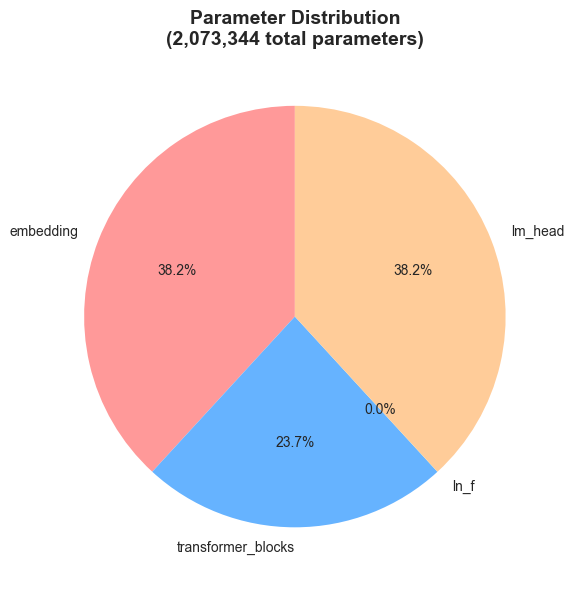


Key Observations:
- Transformer blocks contain most parameters
- Embeddings take significant space (vocab_size × d_model)
- Weight tying reduces lm_head contribution


In [5]:
# Visualize parameter distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Filter out 'total'
components = [k for k in breakdown.keys() if k != 'total']
counts = [breakdown[k] for k in components]

# Create pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax.pie(counts, labels=components, autopct='%1.1f%%', 
       colors=colors, startangle=90)
ax.set_title(f'Parameter Distribution\n({breakdown["total"]:,} total parameters)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Transformer blocks contain most parameters")
print("- Embeddings take significant space (vocab_size × d_model)")
print("- Weight tying reduces lm_head contribution")

## Part 4: Weight Tying Mechanism

Weight tying shares parameters between the token embedding and language modeling head:

In [6]:
# Compare models with and without weight tying
config = get_model_config("small")

model_tied = TinyTransformerLM(vocab_size=10000, tie_weights=True, **config)
model_untied = TinyTransformerLM(vocab_size=10000, tie_weights=False, **config)

params_tied = model_tied.count_parameters()
params_untied = model_untied.count_parameters()
difference = params_untied - params_tied
reduction_pct = (difference / params_untied) * 100

print("Weight Tying Comparison:")
print("=" * 60)
print(f"With weight tying:    {params_tied:>12,} parameters")
print(f"Without weight tying: {params_untied:>12,} parameters")
print(f"Difference:           {difference:>12,} parameters")
print(f"Reduction:            {reduction_pct:>12.1f}%")
print("=" * 60)

# Verify weight sharing
print("\nWeight Sharing Verification:")
emb_weight = model_tied.embedding.token_embedding.embedding.weight
lm_weight = model_tied.lm_head.weight

print(f"Embedding weight shape: {emb_weight.shape}")
print(f"LM head weight shape:   {lm_weight.shape}")
print(f"Same tensor? {emb_weight is lm_weight}")
print(f"Same memory address? {emb_weight.data_ptr() == lm_weight.data_ptr()}")

Weight Tying Comparison:
With weight tying:       7,299,072 parameters
Without weight tying:    9,859,072 parameters
Difference:              2,560,000 parameters
Reduction:                    26.0%

Weight Sharing Verification:
Embedding weight shape: torch.Size([10000, 256])
LM head weight shape:   torch.Size([10000, 256])
Same tensor? True
Same memory address? True


## Part 5: Forward Pass Walkthrough

Let's trace a forward pass through the model step-by-step:

In [7]:
# Create sample input
model_tiny.eval()
batch_size, seq_len = 4, 16
tokens = torch.randint(0, 1000, (batch_size, seq_len))

print(f"Input tokens shape: {tokens.shape}")
print(f"Sample tokens: {tokens[0, :10].tolist()}")
print()

# Step 1: Embedding
with torch.no_grad():
    embedded = model_tiny.embedding(tokens)
    print(f"After embedding: {embedded.shape}")
    print(f"Embedding mean: {embedded.mean():.4f}, std: {embedded.std():.4f}")
    print()
    
    # Step 2: Through transformer blocks
    x = embedded
    for i, block in enumerate(model_tiny.blocks):
        x_before = x.clone()
        x, attn = block(x)
        
        print(f"Block {i+1}: {x.shape}")
        print(f"  Mean: {x.mean():.4f}, Std: {x.std():.4f}")
        print(f"  Change from previous: {(x - x_before).abs().mean():.4f}")
    print()
    
    # Step 3: Final layer norm
    x = model_tiny.ln_f(x)
    print(f"After final LayerNorm: {x.shape}")
    print(f"Mean: {x.mean():.4f}, Std: {x.std():.4f}")
    print()
    
    # Step 4: Language modeling head
    logits = model_tiny.lm_head(x)
    print(f"After LM head: {logits.shape}")
    print(f"Logit mean: {logits.mean():.4f}, std: {logits.std():.4f}")
    print(f"Logit range: [{logits.min():.2f}, {logits.max():.2f}]")

Input tokens shape: torch.Size([4, 16])
Sample tokens: [783, 31, 483, 80, 370, 378, 682, 353, 846, 778]

After embedding: torch.Size([4, 16, 128])
Embedding mean: 0.4504, std: 0.5860

Block 1: torch.Size([4, 16, 128])
  Mean: 0.4539, Std: 0.5863
  Change from previous: 0.0537
Block 2: torch.Size([4, 16, 128])
  Mean: 0.4571, Std: 0.5941
  Change from previous: 0.0517
Block 3: torch.Size([4, 16, 128])
  Mean: 0.4603, Std: 0.6012
  Change from previous: 0.0543
Block 4: torch.Size([4, 16, 128])
  Mean: 0.4663, Std: 0.6024
  Change from previous: 0.0504

After final LayerNorm: torch.Size([4, 16, 128])
Mean: -0.0000, Std: 1.0000

After LM head: torch.Size([4, 16, 10000])
Logit mean: 0.0012, std: 0.2268
Logit range: [-0.95, 1.50]


## Part 6: Hidden State Analysis

Extract and analyze hidden states from each layer:

In [8]:
# Get hidden states
with torch.no_grad():
    logits, hidden_states = model_tiny(tokens, return_hidden_states=True)

print(f"Number of hidden states: {len(hidden_states)}")
print(f"(Embedding output + {len(model_tiny.blocks)} block outputs)")
print()

# Analyze hidden state statistics
for i, h in enumerate(hidden_states):
    layer_name = "Embedding" if i == 0 else f"Block {i}"
    print(f"{layer_name:12s}: mean={h.mean():.4f}, std={h.std():.4f}, "
          f"norm={h.norm(dim=-1).mean():.4f}")

Number of hidden states: 5
(Embedding output + 4 block outputs)

Embedding   : mean=0.4504, std=0.5860, norm=8.3582
Block 1     : mean=0.4543, std=0.5863, norm=8.3884
Block 2     : mean=0.4574, std=0.5941, norm=8.4787
Block 3     : mean=0.4605, std=0.6009, norm=8.5612
Block 4     : mean=0.4659, std=0.6028, norm=8.6145


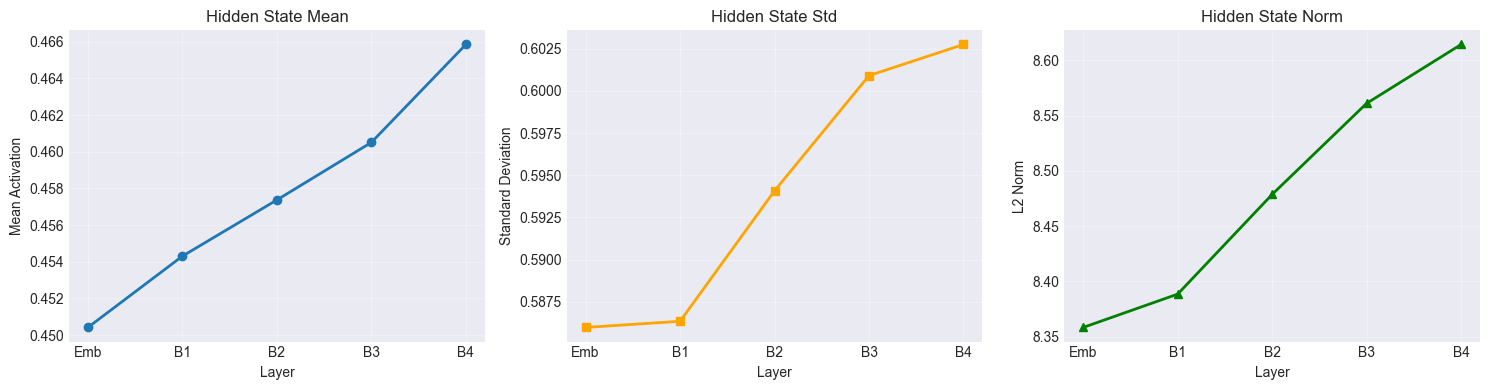


Observations:
- LayerNorm keeps activations normalized across layers
- Residual connections preserve information flow
- Deeper layers show refined representations


In [9]:
# Visualize hidden state evolution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Extract statistics
means = [h.mean().item() for h in hidden_states]
stds = [h.std().item() for h in hidden_states]
norms = [h.norm(dim=-1).mean().item() for h in hidden_states]

layers = list(range(len(hidden_states)))
layer_labels = ["Emb"] + [f"B{i}" for i in range(1, len(hidden_states))]

# Plot mean
axes[0].plot(layers, means, marker='o', linewidth=2)
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Mean Activation')
axes[0].set_title('Hidden State Mean')
axes[0].set_xticks(layers)
axes[0].set_xticklabels(layer_labels)
axes[0].grid(True, alpha=0.3)

# Plot std
axes[1].plot(layers, stds, marker='s', color='orange', linewidth=2)
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Hidden State Std')
axes[1].set_xticks(layers)
axes[1].set_xticklabels(layer_labels)
axes[1].grid(True, alpha=0.3)

# Plot norm
axes[2].plot(layers, norms, marker='^', color='green', linewidth=2)
axes[2].set_xlabel('Layer')
axes[2].set_ylabel('L2 Norm')
axes[2].set_title('Hidden State Norm')
axes[2].set_xticks(layers)
axes[2].set_xticklabels(layer_labels)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- LayerNorm keeps activations normalized across layers")
print("- Residual connections preserve information flow")
print("- Deeper layers show refined representations")

## Part 7: Model Scaling Analysis

How do parameters scale with model size?

In [10]:
# Collect scaling data
scaling_data = []

for size in sizes:
    model = models[size]
    config = configs[size]
    breakdown = model.get_parameter_breakdown()
    
    scaling_data.append({
        'size': size,
        'd_model': config['d_model'],
        'n_layers': config['n_layers'],
        'n_heads': config['n_heads'],
        'd_ff': config['d_ff'],
        'total_params': breakdown['total'],
        'embedding_params': breakdown['embedding'],
        'block_params': breakdown['transformer_blocks'],
    })

# Print scaling table
print("Model Scaling:")
print("=" * 80)
print(f"{'Size':8s} | {'d_model':7s} | {'Layers':6s} | {'Heads':5s} | "
      f"{'Total (M)':>10s} | {'Emb (M)':>8s} | {'Blocks (M)':>10s}")
print("=" * 80)

for data in scaling_data:
    print(f"{data['size']:8s} | {data['d_model']:7d} | {data['n_layers']:6d} | "
          f"{data['n_heads']:5d} | {data['total_params']/1e6:>10.2f} | "
          f"{data['embedding_params']/1e6:>8.2f} | "
          f"{data['block_params']/1e6:>10.2f}")
print("=" * 80)

Model Scaling:
Size     | d_model | Layers | Heads |  Total (M) |  Emb (M) | Blocks (M)
tiny     |     128 |      4 |     4 |       2.07 |     1.28 |       0.79
small    |     256 |      6 |     8 |       7.30 |     2.56 |       4.74
medium   |     512 |      8 |     8 |      30.34 |     5.12 |      25.22
large    |     768 |     12 |    12 |      92.74 |     7.68 |      85.05


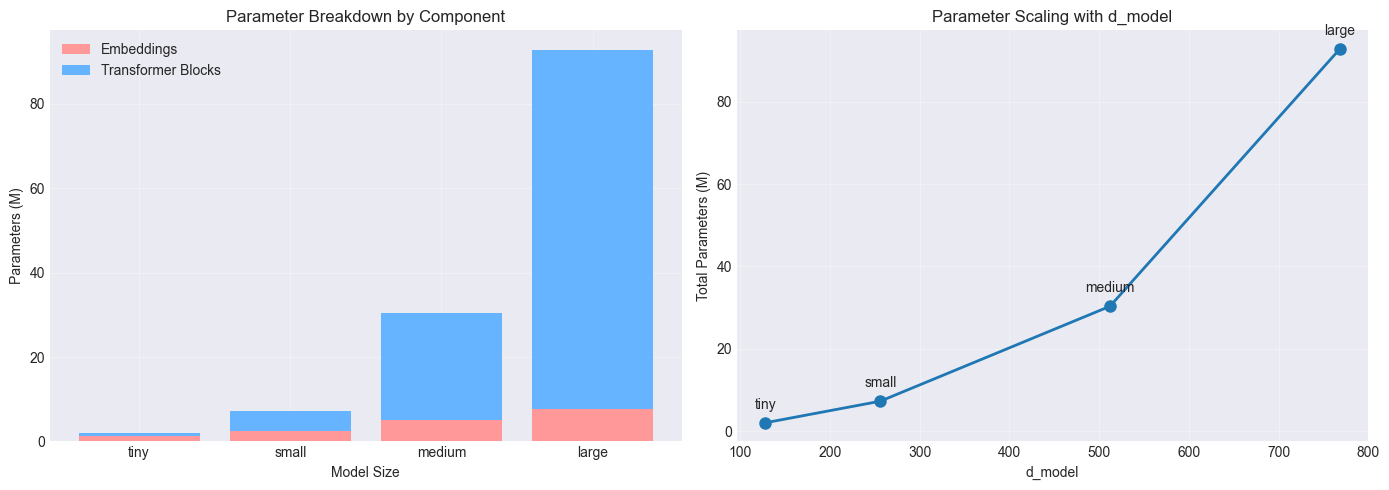


Scaling Observations:
- Parameters scale approximately as O(d_model²) due to attention
- Transformer blocks dominate for large models
- From tiny to large: 44.7× increase


In [11]:
# Visualize parameter scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

size_labels = [d['size'] for d in scaling_data]
total_params = [d['total_params'] / 1e6 for d in scaling_data]
emb_params = [d['embedding_params'] / 1e6 for d in scaling_data]
block_params = [d['block_params'] / 1e6 for d in scaling_data]

# Stacked bar chart
x = np.arange(len(size_labels))
axes[0].bar(x, emb_params, label='Embeddings', color='#ff9999')
axes[0].bar(x, block_params, bottom=emb_params, label='Transformer Blocks', 
            color='#66b3ff')
axes[0].set_xlabel('Model Size')
axes[0].set_ylabel('Parameters (M)')
axes[0].set_title('Parameter Breakdown by Component')
axes[0].set_xticks(x)
axes[0].set_xticklabels(size_labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scaling curve
d_models = [d['d_model'] for d in scaling_data]
axes[1].plot(d_models, total_params, marker='o', linewidth=2, markersize=8)
axes[1].set_xlabel('d_model')
axes[1].set_ylabel('Total Parameters (M)')
axes[1].set_title('Parameter Scaling with d_model')
axes[1].grid(True, alpha=0.3)

# Add annotations
for i, (d, p, s) in enumerate(zip(d_models, total_params, size_labels)):
    axes[1].annotate(s, (d, p), textcoords="offset points", 
                     xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print("\nScaling Observations:")
print(f"- Parameters scale approximately as O(d_model²) due to attention")
print(f"- Transformer blocks dominate for large models")
print(f"- From tiny to large: {total_params[-1]/total_params[0]:.1f}× increase")

## Part 8: Basic Text Generation

Test the model's generation capabilities:

In [12]:
# Generate text
model_tiny.eval()
torch.manual_seed(42)

# Start tokens
start_tokens = torch.randint(0, 1000, (3, 5))  # 3 sequences
max_new_tokens = 15

print("Input sequences:")
for i, seq in enumerate(start_tokens):
    print(f"  Seq {i+1}: {seq.tolist()}")
print()

# Generate
with torch.no_grad():
    generated = model_tiny.generate(
        start_tokens, 
        max_new_tokens=max_new_tokens,
        temperature=1.0
    )

print(f"Generated sequences (length {generated.size(1)}):")
for i, seq in enumerate(generated):
    original = seq[:5].tolist()
    new = seq[5:].tolist()
    print(f"  Seq {i+1}: {original} + {new}")

print(f"\nShape: {generated.shape}")
print(f"Expected: (3, {5 + max_new_tokens})")

Input sequences:
  Seq 1: [542, 67, 876, 414, 26]
  Seq 2: [335, 620, 924, 950, 113]
  Seq 3: [378, 14, 210, 954, 231]



Generated sequences (length 20):
  Seq 1: [542, 67, 876, 414, 26] + [793, 3937, 4336, 2038, 433, 1921, 7904, 6055, 2627, 3242, 6630, 2373, 1669, 8623, 2440]
  Seq 2: [335, 620, 924, 950, 113] + [7829, 8707, 4581, 6062, 6764, 8195, 1472, 3318, 1782, 5148, 4158, 7637, 4057, 6358, 1985]
  Seq 3: [378, 14, 210, 954, 231] + [574, 6624, 4721, 1805, 364, 250, 3583, 8989, 5566, 4062, 4740, 9419, 5784, 9438, 3933]

Shape: torch.Size([3, 20])
Expected: (3, 20)


In [13]:
# Test different temperatures
temperatures = [0.5, 1.0, 2.0]
start_single = torch.randint(0, 1000, (1, 5))

print("Generation with different temperatures:")
print(f"Start sequence: {start_single[0].tolist()}")
print()

for temp in temperatures:
    torch.manual_seed(100)  # Same seed for comparison
    with torch.no_grad():
        gen = model_tiny.generate(
            start_single,
            max_new_tokens=10,
            temperature=temp
        )
    
    new_tokens = gen[0, 5:].tolist()
    print(f"T={temp:.1f}: {new_tokens}")

print()
print("Notes:")
print("- Lower temperature → more deterministic")
print("- Higher temperature → more random")
print("- Temperature controls diversity of outputs")

Generation with different temperatures:
Start sequence: [937, 845, 586, 107, 165]

T=0.5: [7438, 6313, 1266, 6752, 3527, 6282, 3293, 4533, 6627, 1665]


T=1.0: [7438, 6395, 1266, 6752, 3527, 6282, 88, 4533, 6627, 1665]
T=2.0: [7438, 6395, 1266, 6752, 3527, 6282, 88, 4533, 6627, 1665]

Notes:
- Lower temperature → more deterministic
- Higher temperature → more random
- Temperature controls diversity of outputs


## Part 9: Memory Estimation

Estimate memory requirements for different model sizes:

In [14]:
def estimate_model_memory(model, dtype=torch.float32):
    """Estimate model memory in MB."""
    bytes_per_param = 4 if dtype == torch.float32 else 2  # fp32 vs fp16
    
    # Model parameters
    num_params = model.count_parameters()
    param_memory = num_params * bytes_per_param / (1024 ** 2)  # MB
    
    # Gradients (during training)
    grad_memory = param_memory  # Same size as parameters
    
    # Optimizer states (AdamW has 2× params for momentum and variance)
    optimizer_memory = 2 * param_memory
    
    return {
        'parameters': param_memory,
        'gradients': grad_memory,
        'optimizer': optimizer_memory,
        'total_training': param_memory + grad_memory + optimizer_memory,
        'inference_only': param_memory
    }

# Estimate for all model sizes
print("Memory Estimation (FP32):")
print("=" * 90)
print(f"{'Size':8s} | {'Params':>10s} | {'Inference':>10s} | "
      f"{'Training':>10s} | {'Total':>10s}")
print("=" * 90)

for size in sizes:
    model = models[size]
    mem = estimate_model_memory(model)
    
    print(f"{size:8s} | {model.count_parameters()/1e6:>9.2f}M | "
          f"{mem['inference_only']:>9.1f}MB | "
          f"{mem['total_training']:>9.1f}MB | "
          f"{mem['total_training']/1024:>9.2f}GB")
print("=" * 90)

print("\nNote: This excludes activation memory which depends on batch size!")

Memory Estimation (FP32):
Size     |     Params |  Inference |   Training |      Total
tiny     |      2.07M |       7.9MB |      31.6MB |      0.03GB
small    |      7.30M |      27.8MB |     111.4MB |      0.11GB
medium   |     30.34M |     115.7MB |     463.0MB |      0.45GB
large    |     92.74M |     353.8MB |    1415.0MB |      1.38GB

Note: This excludes activation memory which depends on batch size!


In [15]:
def estimate_activation_memory(model, batch_size, seq_len, dtype=torch.float32):
    """Estimate activation memory for a forward pass."""
    bytes_per_element = 4 if dtype == torch.float32 else 2
    
    d_model = model.d_model
    n_layers = model.n_layers
    n_heads = model.n_heads
    d_ff = model.d_ff
    
    # Embedding output
    emb_mem = batch_size * seq_len * d_model * bytes_per_element
    
    # Per transformer block:
    # - Attention: Q, K, V, attention scores, attention output
    qkv_mem = 3 * batch_size * seq_len * d_model * bytes_per_element
    attn_scores_mem = batch_size * n_heads * seq_len * seq_len * bytes_per_element
    attn_out_mem = batch_size * seq_len * d_model * bytes_per_element
    
    # - Feed-forward: intermediate activation
    ff_mem = batch_size * seq_len * d_ff * bytes_per_element
    
    # - Residuals and layer norms
    residual_mem = 2 * batch_size * seq_len * d_model * bytes_per_element
    
    block_mem = qkv_mem + attn_scores_mem + attn_out_mem + ff_mem + residual_mem
    total_block_mem = block_mem * n_layers
    
    total_mem = (emb_mem + total_block_mem) / (1024 ** 2)  # MB
    
    return total_mem

# Estimate activation memory for different batch sizes
batch_sizes = [1, 4, 16, 32]
seq_length = 512

print(f"\nActivation Memory (seq_len={seq_length}, FP32):")
print("=" * 70)
print(f"{'Model':8s} | " + " | ".join([f"B={b:2d}" for b in batch_sizes]))
print("=" * 70)

for size in ["tiny", "small"]:
    model = models[size]
    mems = [estimate_activation_memory(model, b, seq_length) for b in batch_sizes]
    mem_str = " | ".join([f"{m:>6.1f}MB" for m in mems])
    print(f"{size:8s} | {mem_str}")
print("=" * 70)

print("\nKey Takeaways:")
print("- Activation memory scales linearly with batch size")
print("- Attention scores dominate memory (O(seq_len²))")
print("- Total GPU memory = Model + Gradients + Optimizer + Activations")


Activation Memory (seq_len=512, FP32):
Model    | B= 1 | B= 4 | B=16 | B=32
tiny     |   26.2MB |  105.0MB |  420.0MB |  840.0MB
small    |   78.5MB |  314.0MB | 1256.0MB | 2512.0MB

Key Takeaways:
- Activation memory scales linearly with batch size
- Attention scores dominate memory (O(seq_len²))
- Total GPU memory = Model + Gradients + Optimizer + Activations


## Summary: Key Takeaways

### Architecture
1. **Complete Integration**: TinyTransformerLM combines embeddings, transformer blocks, and LM head
2. **Pre-LN Architecture**: Layer normalization before sub-layers for stability
3. **Causal Masking**: Lower-triangular mask prevents looking ahead

### Weight Tying
1. **Mechanism**: Share weights between token embedding and LM head
2. **Benefits**: 15-20% parameter reduction with similar performance
3. **Implementation**: Direct weight reference (same tensor)

### Parameter Scaling
1. **Dominance**: Transformer blocks contain most parameters (~70-80%)
2. **Scaling**: Parameters grow as O(d_model²) and O(n_layers)
3. **Trade-off**: More parameters → better capacity but more memory

### Memory Requirements
1. **Training**: Model + gradients + optimizer states (4× model size)
2. **Inference**: Just model parameters (1× model size)
3. **Activations**: Depend on batch_size × seq_len (O(seq_len²) attention)

### Generation
1. **Autoregressive**: Generate one token at a time
2. **Temperature**: Controls randomness vs determinism
3. **Context Window**: Limited by max_len (truncate if exceeded)

### Next Steps
- **Module 06**: Training the model (optimizers, loss, data loading)
- **Module 07**: Advanced generation (top-k, nucleus sampling, beam search)
- **Module 08**: Scaling to larger models and datasets

## Exercise

Try the following:
1. Create a custom model configuration between "small" and "medium"
2. Analyze its parameter breakdown
3. Compare weight tying vs no weight tying
4. Estimate memory requirements for batch_size=64, seq_len=1024
5. Generate text with different temperatures and compare outputs

See `exercises/exercises.py` for more structured exercises!